In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import torch

from transformers import AutoTokenizer
from datasets import load_dataset
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.nn.functional import cross_entropy
from app.modeling.model import TweetClassificationModel

## Load Data

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
emotions_ds = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
class_names = emotions_ds["train"].features["label"].names
class_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [5]:
MODEL_CHKPT = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHKPT)

tokenizer("this is a test in order to see if the encoder is working", return_tensors="pt")

{'input_ids': tensor([[  101,  2023,  2003,  1037,  3231,  1999,  2344,  2000,  2156,  2065,
          1996,  4372, 16044,  2099,  2003,  2551,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [6]:
def tokenize_batch(batch):
    return tokenizer(batch["text"], 
                     padding=True,
                     truncation=True,
                     add_special_tokens=True,
                     return_tensors="pt")

In [7]:
tweets_encoded = emotions_ds.map(tokenize_batch, batched=True, batch_size=None)

Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-b324fc8d9823e7f9.arrow
Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-1a6f8804dcb677d0.arrow
Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-3f93778ab3d480f2.arrow


In [8]:
tweets_encoded.set_format("torch",
                          columns=["input_ids", "attention_mask", "label"])

## Load Model

In [9]:
saved_model_name = "distilbert-base-finetuned-for-tweet-classification"

model = TweetClassificationModel(MODEL_CHKPT, len(class_names))
model.load_state_dict(
                torch.load(f"app/modeling/models/{saved_model_name}.pth")
            )
model = model.to(torch.device("mps"))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Evaluate the model

In [10]:
def forward_pass_with_label(batch):
    with torch.inference_mode():

        inputs = {k:v.to(torch.device("mps")) for k,v in batch.items() if k in tokenizer.model_input_names}

        output = model(input_ids = inputs["input_ids"],
                       attention_mask = inputs["attention_mask"],
                       labels=None)

        pred_label = torch.argmax(output["logits"], dim=1)

        loss = cross_entropy(input=output.logits, target=batch["label"].to(torch.device("mps")), reduction="none")

    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }

In [11]:
tweets_encoded["test"] = tweets_encoded["test"].map(forward_pass_with_label, batched=True, batch_size=16)

/Users/davidbreinl/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646991213/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [12]:
tweets_encoded.set_format("pandas")

In [13]:
loss_df = tweets_encoded["test"][:][["text", "label",  "loss", "predicted_label"]]
loss_df["true_label"] = [class_names[sentiment] for sentiment in loss_df["label"]]
loss_df["predicted_label"] = [class_names[sentiment] for sentiment in loss_df["predicted_label"]]

In [14]:
loss_df.sort_values("loss", ascending=False).head(30)

,text,label,loss,predicted_label,true_label
816,whenever i put myself in others shoes and try to make the person happy,3,8.944002,joy,anger
1928,i feel inside cause life is like a game sometimes but then you came around me the walls just disappeared nothing to surround me and keep me from my fears im unprotected see how ive opened up youve made me trust,4,8.523156,sadness,fear
1613,i feel very cheated since i am supporting the family and doing all the other stuff while he spends hours a day gaming,1,6.955326,sadness,joy
150,im feeling rather angsty and listless,0,6.898370,love,sadness
1253,i don t feel betrayed coz the backstabber had no grounds for their accusation but i m just amazed at some people s ability to do such things,5,5.470772,sadness,surprise
1270,i feel very saddened that the king whom i once quite respected as far as monarchs go was ineffectual at best,1,4.646597,sadness,joy
1837,i hate these feelings in my heart i hate that work stressed me out i hate that cornelius wont let me get my way im frustrated lord,0,4.568183,anger,sadness
125,i feel very mislead by someone that i really really thought i knew and liked very much so,2,4.535568,anger,love
1377,i walked to school he felt the bounce in his step the overjoyed feelings of youth and the thrill of excitement of coming to school and meeting his beloved friends,2,4.344568,joy,love
1206,ive come to feel about a supporting character in one of my all time favorite films giant,1,4.018548,love,joy


In [15]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

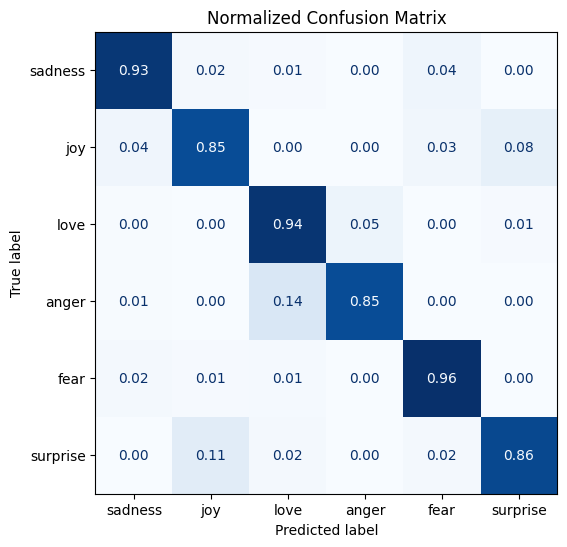

In [16]:
plot_confusion_matrix(loss_df["predicted_label"], loss_df["true_label"], labels=class_names)